# Predicting the Past, United States Extension

## Introduction
This is an extension of Predicting the Past, United States. 
The extension includes comparisons between _CYCLUS_ output and CURIE data for the United States from 1968 to 2013 for: 
 - Total spent fuel mass 
 - Mass of major isotopes in spent fuel 

The CURIE data is taken from UNF_ST&DARDS Unified Database and the Automatic Document Generator. 

The _CYCLUS_ data was generated by using published data of the commericial reactors that have operated in the United States. The _CYCLUS_ input file and simulation were generated in the original Predicting the Past, United States notebook. This notebook uses the SQL data file produced from the _CYCLUS_ simulation to do further analysis. 

** Import necessary libraries ** 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import csv
import collections
import dateutil.parser as date
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import sqlite3 as lite
from matplotlib import cm
from pyne import nucname as nn
from IPython.display import Image, HTML, display

sys.path.append('../../../scripts/')
import analysis as an

## CURIE Data Analysis

** Import CURIE data from dat file into a dataframe (deleted the heading of the dat file)** 

In [20]:
names = ['assembly_id','reactor_id', 'reactor_type', 'initial_uranium_kg','initial_enrichment','discharge_burnup','discharge_date','discharge_time','total_assembly_decay_heat_kw','name','evaluation_date','total_mass_g','total_radioactivity_curies']
df = pd.read_csv('SNF_nuclide_2020_07_01.dat',
                  sep='\s+',
                  index_col=False, 
                  names = names)

** Rearrange dataframe to only keep relevant columns **

In [21]:
date_isotope_mass = df[['discharge_date','name','total_mass_g']]
date_mass = df[['discharge_date','total_mass_g']]

** Rearrange dataframe to sum spent fuel mass by discharge date ** 

In [22]:
spent_fuel_mass = date_mass.groupby('discharge_date').sum()
spent_fuel_mass_cum = spent_fuel_mass.cumsum()
spent_fuel_mass_cum['total_mass_g'] = spent_fuel_mass_cum['total_mass_g'].apply(lambda x: x*0.000001)
spent_fuel_mass_cum = spent_fuel_mass_cum.rename(columns = {'total_mass_g':'total_mass_MTHM_CURIE'})
spent_fuel_mass_cum.index.names = ['discharge_date']

** Plot of Cumulative mass of spent fuel against discharge year from CURIE data ** 

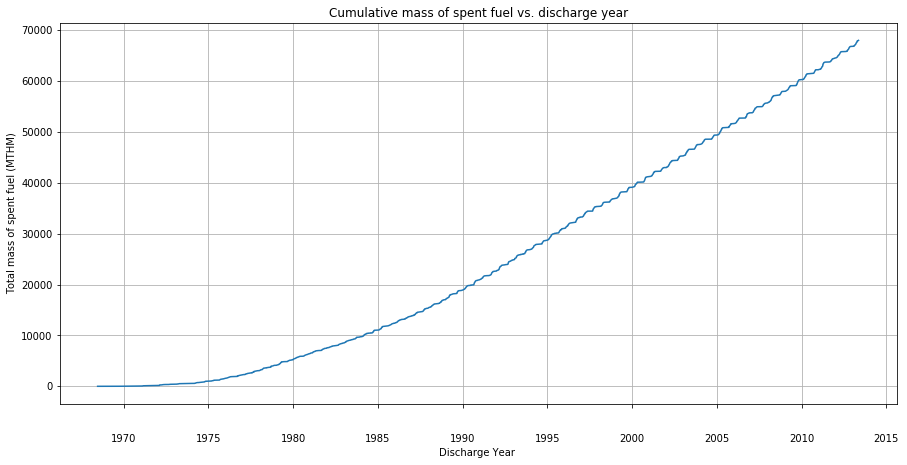

In [23]:
index = spent_fuel_mass_cum.index.values
data = spent_fuel_mass_cum.values
dts = pd.to_datetime(index)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data)
ax.grid()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ')
ax.set_ylabel('Total mass of spent fuel (MTHM)')
ax.set_title('Cumulative mass of spent fuel vs. discharge year')
plt.savefig('figures/cumulative_mass_spent_fuel.png', dpi=300)

** Rearrange dataframe to sum spent fuel mass by discharge date and name of isotope ** 

In [ ]:
CURIE_isotope = date_isotope_mass.pivot_table(index='discharge_date',columns='name',aggfunc=sum)
CURIE_isotope_cum = CURIE_isotope.cumsum()
CURIE_isotope_single = CURIE_isotope_cum.loc[:,('total_mass_g', 'u-238')]
CURIE_isotope_single = CURIE_isotope_single.to_frame()
CURIE_isotope_single = CURIE_isotope_single.multiply(0.000001)

** Plot of Cumulative spent fuel isotope mass against discharge time from CURIE data ** 

In [ ]:
index = CURIE_isotope_single.index.values
column = list(CURIE_isotope_single.columns.values)
data = CURIE_isotope_single.values
dts = pd.to_datetime(index)
col_no = -1

for col in column:
    col_no = col_no + 1 
    if 'u-238' in col: # Insert your chosen isotope here to get its plot 
        column_single = col_no

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data)
ax.grid()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ')
ax.set_ylabel('Total mass of spent fuel (MTHM)')
ax.set_title(str(column[column_single]) + 'Cumulative mass of spent fuel vs. discharge year')
plt.savefig('figures/cumulative_mass_spent_fuel.png', dpi=300)

## CYCLUS Data Analysis

** Setting up to query united_states.sqlite generated by Predicting the Past, United States Notebook ** 

In [39]:
def get_cursor(file_name):
    """ Connects and returns a cursor to an sqlite output file

    Parameters
    ----------
    file_name: str
        name of the sqlite file

    Returns
    -------
    sqlite cursor
    """
    con = lite.connect(file_name)
    con.row_factory = lite.Row
    return con.cursor()


cursor = get_cursor('cyclus/united_states.sqlite')
cursor_refuel3 = get_cursor('cyclus/united_states_refueltime3.sqlite')
cursor_refuel4 = get_cursor('cyclus/united_states_refueltime4.sqlite')
cursor_refuel1_burnup33 = get_cursor('cyclus/united_states_refueltime1_burnup33.sqlite')
cursor_refuel1_burnup100 = get_cursor('cyclus/united_states_refueltime1_burnup100.sqlite')

In [7]:
def get_timesteps(cur):
    """ Returns simulation start year, month, duration and
    timesteps (in numpy linspace).

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    init_year: int
        start year of simulation
    init_month: int
        start month of simulation
    duration: int
        duration of simulation
    timestep: list
        linspace up to duration
    """
    info = cur.execute('SELECT initialyear, initialmonth, '
                       'duration FROM info').fetchone()
    init_year = info['initialyear']
    init_month = info['initialmonth']
    duration = info['duration']
    timestep = np.linspace(0, duration - 1, num=duration)

    return init_year, init_month, duration, timestep

ini_yr, ini_month, dur, timestep = get_timesteps(cursor)

** Getting cumulative spent fuel produced ** 

In [8]:
def spent_fuel_produced(cur): 
    """ Find timeseries of mass of spent fuel output by reactors 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    timeseries list of spent fuel output by reactors
    """

    init_yr, init_month, duration, timestep = get_timesteps(cursor)
    spent_fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                             'INNER JOIN resources '
                             'ON transactions.resourceid = resources.resourceid '
                             'WHERE Commodity = "spent_uox" '
                             'GROUP BY time ').fetchall()
    return an.get_timeseries_cum(spent_fuel,duration,True)

** Plot of Cumulative mass of spent fuel (refuel time = 1) against discharge year from CYCLUS data ** 

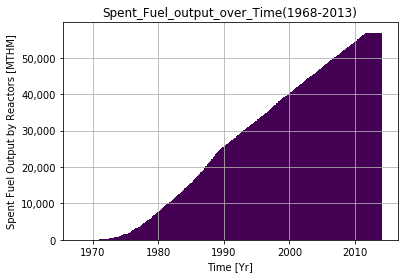

In [9]:
start_year = 1968
end_year = 2014
start_index = (start_year - 1965) * 12
end_index = (end_year - 1965) * 12
dura = end_year - start_year
init_yr, init_month, duration, timestep = an.get_timesteps(cursor)

timestep_range = timestep[start_index: end_index]
full_range = spent_fuel_produced(cursor)
generated_range = full_range[start_index: end_index]

img_out = 'figures/'
pathlib.Path(img_out).mkdir(parents=True, exist_ok=True)
name = 'Spent_Fuel_output_over_Time(1968-2013)'
output_reactor = {'Spent_Fuel_Output': generated_range}
an.stacked_bar_chart(output_reactor, timestep_range,
                     'Time [Yr]', 'Spent Fuel Output by Reactors [MTHM]',
                     name, img_out + name, init_yr)
    
Image(filename=img_out + name + '.png')

** Plot of Cumulative mass of spent fuel (refuel time = 3) against discharge year from CYCLUS data ** 

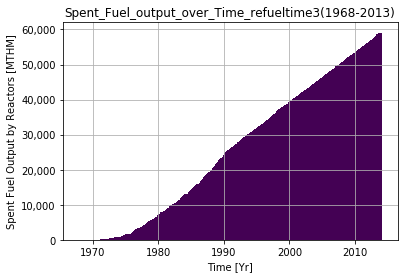

In [13]:
start_year = 1968
end_year = 2014
start_index = (start_year - 1965) * 12
end_index = (end_year - 1965) * 12
dura = end_year - start_year
init_yr, init_month, duration, timestep = an.get_timesteps(cursor_refuel3)

timestep_range = timestep[start_index: end_index]
full_range = spent_fuel_produced(cursor_refuel3)
generated_range_refueltime3 = full_range[start_index: end_index]

img_out = 'figures/'
pathlib.Path(img_out).mkdir(parents=True, exist_ok=True)
name = 'Spent_Fuel_output_over_Time_refueltime3(1968-2013)'
output_reactor = {'Spent_Fuel_Output': generated_range_refueltime3}
an.stacked_bar_chart(output_reactor, timestep_range,
                     'Time [Yr]', 'Spent Fuel Output by Reactors [MTHM]',
                     name, img_out + name, init_yr)
    
Image(filename=img_out + name + '.png')

** Plot of Cumulative mass of spent fuel (refuel time = 4) against discharge year from CYCLUS data ** 

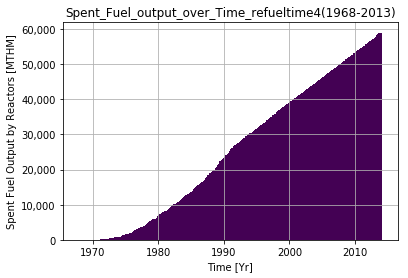

In [12]:
start_year = 1968
end_year = 2014
start_index = (start_year - 1965) * 12
end_index = (end_year - 1965) * 12
dura = end_year - start_year
init_yr, init_month, duration, timestep = an.get_timesteps(cursor_refuel4)

timestep_range = timestep[start_index: end_index]
full_range = spent_fuel_produced(cursor_refuel4)
generated_range_refueltime4 = full_range[start_index: end_index]

img_out = 'figures/'
pathlib.Path(img_out).mkdir(parents=True, exist_ok=True)
name = 'Spent_Fuel_output_over_Time_refueltime4(1968-2013)'
output_reactor = {'Spent_Fuel_Output': generated_range_refueltime4}
an.stacked_bar_chart(output_reactor, timestep_range,
                     'Time [Yr]', 'Spent Fuel Output by Reactors [MTHM]',
                     name, img_out + name, init_yr)
    
Image(filename=img_out + name + '.png')

** Plot of Cumulative mass of spent fuel (refuel time = 1 , burn up = 33) against discharge year from CYCLUS data ** 

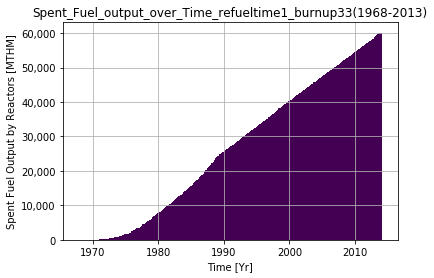

In [30]:
start_year = 1968
end_year = 2014
start_index = (start_year - 1965) * 12
end_index = (end_year - 1965) * 12
dura = end_year - start_year
init_yr, init_month, duration, timestep = an.get_timesteps(cursor_refuel1_burnup33)

timestep_range = timestep[start_index: end_index]
full_range = spent_fuel_produced(cursor_refuel1_burnup33)
generated_range_refueltime1_burnup33 = full_range[start_index: end_index]

img_out = 'figures/'
pathlib.Path(img_out).mkdir(parents=True, exist_ok=True)
name = 'Spent_Fuel_output_over_Time_refueltime1_burnup33(1968-2013)'
output_reactor = {'Spent_Fuel_Output': generated_range_refueltime1_burnup33}
an.stacked_bar_chart(output_reactor, timestep_range,
                     'Time [Yr]', 'Spent Fuel Output by Reactors [MTHM]',
                     name, img_out + name, init_yr)
    
Image(filename=img_out + name + '.png')

** Plot of Cumulative mass of spent fuel (refuel time = 1 , burn up = 100) against discharge year from CYCLUS data ** 

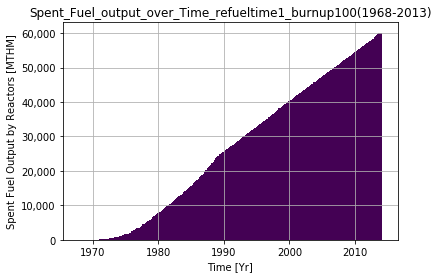

In [40]:
start_year = 1968
end_year = 2014
start_index = (start_year - 1965) * 12
end_index = (end_year - 1965) * 12
dura = end_year - start_year
init_yr, init_month, duration, timestep = an.get_timesteps(cursor_refuel1_burnup100)

timestep_range = timestep[start_index: end_index]
full_range = spent_fuel_produced(cursor_refuel1_burnup100)
generated_range_refueltime1_burnup100 = full_range[start_index: end_index]

img_out = 'figures/'
pathlib.Path(img_out).mkdir(parents=True, exist_ok=True)
name = 'Spent_Fuel_output_over_Time_refueltime1_burnup100(1968-2013)'
output_reactor = {'Spent_Fuel_Output': generated_range_refueltime1_burnup100}
an.stacked_bar_chart(output_reactor, timestep_range,
                     'Time [Yr]', 'Spent Fuel Output by Reactors [MTHM]',
                     name, img_out + name, init_yr)
    
Image(filename=img_out + name + '.png')

** Plot of Cumulative spent fuel isotope mass against discharge time from CURIE data ** 

In [ ]:
start_year = 1968
end_year = 2014
start_index = (start_year - 1965) * 12
end_index = (end_year - 1965) * 12
dura = end_year - start_year
init_yr, init_month, duration, timestep = an.get_timesteps(cursor)

def isotope_list(cur):
    """ Find list of isotopes present in spent fuel output by reactor 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    list of isotopes in spent fuel output by reactors
    """   
    
    init_yr, init_month, duration, timestep = an.get_timesteps(cursor)
    isotopes = cur.execute('SELECT time, sum(quantity)*massfrac FROM transactions '
                           'INNER JOIN resources '
                           'ON transactions.resourceid = resources.resourceid '
                           'LEFT OUTER JOIN compositions '
                           'ON resources.qualid = compositions.qualid '
                           'WHERE Commodity = "spent_uox" AND nucid = 922380000 ' # change isotope no. here
                           ' GROUP BY time ').fetchall()
    return an.get_timeseries_cum(isotopes,duration,True)

timestep_range = timestep[start_index: end_index]
full_range = isotope_list(cursor)
generated_range_isotope = full_range[start_index: end_index]

img_out = 'figures/'
pathlib.Path(img_out).mkdir(parents=True, exist_ok=True)
name = '922380000_cum_Spent_Fuel_output_over_Time(1968~2013)' # change isotope no. here
isotope_output_reactor = {'Isotopes_Spent_Fuel_Output': generated_range_isotope}
an.stacked_bar_chart(isotope_output_reactor, timestep_range,
                     'Time [Yr]', 'Isotope (922380000) Cumulative Spent Fuel Output by Reactors [MTHM]', # change isotope no. here
                     name, img_out + name, 1965) 
    
Image(filename=img_out + name + '.png')

## Cumulative Spent Fuel (1968 - 2013) for CURIE and Cyclus on the same plot 

** Set up CYCLUS dataframe ** 

In [41]:
cyclus_dates = pd.date_range(start='1/1/1968', periods=552, freq='M')
cyclus_data = pd.DataFrame({'discharge_date':cyclus_dates, 'total_mass_MTHM_cyclus_refueltime1': generated_range})
cyclus_data = cyclus_data.set_index('discharge_date')
cyclus_data.index.names = ['discharge_date']

cyclus_dates_refueltime3 = pd.date_range(start='1/1/1968', periods=552, freq='M')
cyclus_data_refueltime3 = pd.DataFrame({'discharge_date':cyclus_dates, 'total_mass_MTHM_cyclus_refueltime3': generated_range_refueltime3})
cyclus_data_refueltime3 = cyclus_data_refueltime3.set_index('discharge_date')
cyclus_data_refueltime3.index.names = ['discharge_date']

cyclus_dates_refueltime4 = pd.date_range(start='1/1/1968', periods=552, freq='M')
cyclus_data_refueltime4 = pd.DataFrame({'discharge_date':cyclus_dates, 'total_mass_MTHM_cyclus_refueltime4': generated_range_refueltime4})
cyclus_data_refueltime4 = cyclus_data_refueltime4.set_index('discharge_date')
cyclus_data_refueltime4.index.names = ['discharge_date']

cyclus_dates_refueltime1_burnup33 = pd.date_range(start='1/1/1968', periods=552, freq='M')
cyclus_data_refueltime1_burnup33 = pd.DataFrame({'discharge_date':cyclus_dates, 'total_mass_MTHM_cyclus_refueltime1_burnup33': generated_range_refueltime1_burnup33})
cyclus_data_refueltime1_burnup33 = cyclus_data_refueltime1_burnup33.set_index('discharge_date')
cyclus_data_refueltime1_burnup33.index.names = ['discharge_date']

cyclus_dates_refueltime1_burnup100 = pd.date_range(start='1/1/1968', periods=552, freq='M')
cyclus_data_refueltime1_burnup100 = pd.DataFrame({'discharge_date':cyclus_dates, 'total_mass_MTHM_cyclus_refueltime1_burnup100': generated_range_refueltime1_burnup100})
cyclus_data_refueltime1_burnup100 = cyclus_data_refueltime1_burnup100.set_index('discharge_date')
cyclus_data_refueltime1_burnup100.index.names = ['discharge_date']

** Set up Combined dataframe ** 

In [42]:
combined_data = spent_fuel_mass_cum.join(cyclus_data, how='outer')
combined_data_refueltime3 = combined_data.join(cyclus_data_refueltime3, how='left')
combined_data_refueltime4 = combined_data_refueltime3.join(cyclus_data_refueltime4, how='left')
combined_data_refueltime1_burnup33 = combined_data_refueltime4.join(cyclus_data_refueltime1_burnup33, how='left')
combined_data_refueltime1_burnup100 = combined_data_refueltime1_burnup33.join(cyclus_data_refueltime1_burnup100, how='left')

** Plot of CURIE and CYCLUS Cumulative mass of spent fuel against discharge year ** 

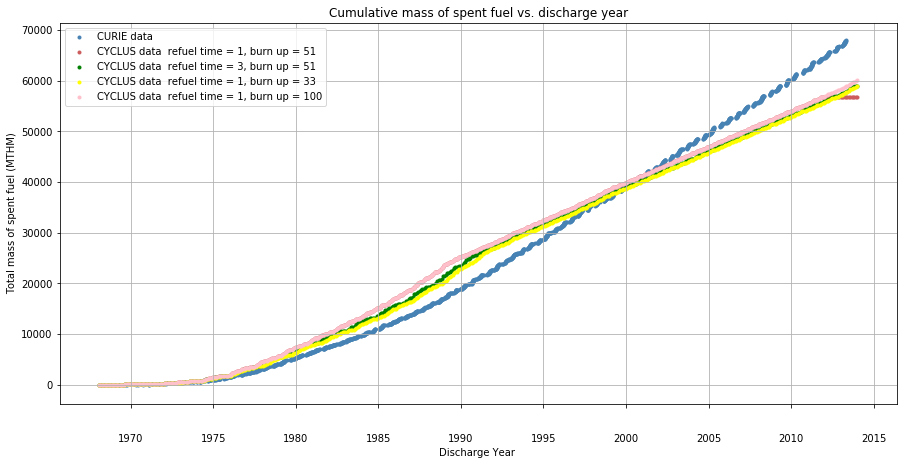

In [45]:
index = combined_data_refueltime1_burnup100.index.values
data = combined_data_refueltime1_burnup100.values
dts = pd.to_datetime(index)

fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dts, data[:,0], color = 'steelblue', label='CURIE data', marker = ".")
ax.scatter(dts, data[:,1], color = 'indianred', label='CYCLUS data  refuel time = 1, burn up = 51', marker = ".")
ax.scatter(dts, data[:,2], color = 'green', label='CYCLUS data  refuel time = 3, burn up = 51', marker = ".")
#ax.scatter(dts, data[:,3], color = 'orange', label='CYCLUS data  refuel time = 4, burn up = 51', marker = ".")
ax.scatter(dts, data[:,3], color = 'yellow', label='CYCLUS data  refuel time = 1, burn up = 33', marker = ".")
ax.scatter(dts, data[:,4], color = 'pink', label='CYCLUS data  refuel time = 1, burn up = 100', marker = ".")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ')
ax.set_ylabel('Total mass of spent fuel (MTHM)')
ax.set_title('Cumulative mass of spent fuel vs. discharge year')
plt.savefig('figures/total_cumulative_mass_spent_fuel_refueltime3.png', dpi=300)

### Explanation of Plot 
In the above plot, the cumulative total mass of spent fuel over discharge year follow the same general trend. There is a slightly higher overall total mass from _CYCLUS_ data compared to the CURIE data. 

The reason for the discrepancy is due to the assumption made that refuelling time is always 1 month in the _CYCLUS_ simulations. _CYCLUS_ is only capable of entering month long integer values as refuelling time. However, in the real-world, refuelling times vary and may not fall exactly at month lengthed times. 

According to the Nuclear Energy Institute (NEI), there has been significant variance in the refueling period for reactors in the United States. The average refuelling time in 1990 was 104 days, and generally decreased to an average refuelling time of 35 days in 2017. As published by the NEI, the average refuelling time of nuclear reactors between 1990 and 2017 in the United States is greater than 1 month [cite: NEI]. 

This means that the refuelling time of the reactors in the _CYCLUS_ simulation is smaller than the average real-world refuelling times from 1968 to 2013. A smaller refuelling time corresponds to higher burn up of the spent fuel since the fuel spends a shorter time in the reactor for the same lifetime. Therefore, the reactor fuel in the _CYCLUS_ simulation has an average higher burn up than the real world. 

The most significant isotope contributer to the total mass of the spent fuel is U-238. According to ORNL [cite: francis_reactor], the concentration of U-238 decreases with burn up. The plot of the variation of the total spent fuel mass of U-238 from 1968 to 2013 and the plot of the relationship between concentration of U-238 and burn up can be found in the U-238 section below. 

Therefore, since the average burn up of reactor fuel in the _CYCLUS_ simulation is larger than the average burn up in the CURIE data, there would be a higher average concentration of U-238 in the final spent fuel composition in the CURIE data compared to the _CYCLUS_ data. This is reflected in the plot. 

??: It is unclear why the amount of total spent fuel and U-238 is higher for the _CYCLUS_ data compared to the CURIE data pre-2000. Since it means that the burn up is smaller for _CYCLUS_ simulation spent fuel compared to the CURIE simulation spent fuel during that time. 


## Cumulative Major Isotopes Spent Fuel (1968 - 2013) for CURIE and CYCLUS on the same plot  

The isotopes that contribute the most to the total mass of the spent fuel in order of significance are: 
1. U-238  (922380000)
2. U-235  (922350000)
3. Pu-239 (942390000)
4. U-236  (922360000)
5. Pu-240 (942400000)

The actinides in the spent fuel that contribute the most to short term decay heat (~100 years) are: 
1. Pu-238 (942380000)
2. Cm-244 (962440000)
3. Cs-137 (551370000)

The actinides in the spent fuel that contribute the most to mid-term decay heat (~1000 years) are: 
1. Am-241 (952410000)

The actinides in the spent fuel that contribute the most to long term decay heat (~10000 years) are: 
1. Pu-240 
2. Pu-239

The decay heat significance is taken Wigeland et al [cite] and is shown in the figure below.  

In [ ]:
Image(filename='figures/Wigeland_decayheat.png', width = 500, height = 500)

### General Framework for setting up Plot for CURIE and CYCLUS isotopic mass values

** Set up CURIE dataframe**

In [ ]:
CURIE_isotope_single = CURIE_isotope.loc[:,('total_mass_g', 'am-241')] # specify isotope
CURIE_isotope_single = CURIE_isotope_single.to_frame()
CURIE_isotope_single = CURIE_isotope_single.multiply(0.000001)

** Set up CYCLUS dataframe**

In [ ]:
start_year = 1968
end_year = 2014
start_index = (start_year - 1965) * 12
end_index = (end_year - 1965) * 12
dura = end_year - start_year
init_yr, init_month, duration, timestep = an.get_timesteps(cursor)

def isotope_list(cur):
    """ Find list of isotopes present in spent fuel output by reactor 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    list of isotopes in spent fuel output by reactors
    """   
    
    init_yr, init_month, duration, timestep = an.get_timesteps(cursor)
    isotopes = cur.execute('SELECT time, sum(quantity)*massfrac FROM transactions '
                           'INNER JOIN resources '
                           'ON transactions.resourceid = resources.resourceid '
                           'LEFT OUTER JOIN compositions '
                           'ON resources.qualid = compositions.qualid '
                           'WHERE Commodity = "spent_uox" AND nucid = 952410000 ' # specify isotope
                           ' GROUP BY time ').fetchall()
    return an.get_timeseries(isotopes,duration,True)

timestep_range = timestep[start_index: end_index]
full_range = isotope_list(cursor)
generated_range_isotope = full_range[start_index: end_index]

cyclus_dates = pd.date_range(start='1/1/1968', periods=552, freq='M')
cyclus_data_isotope = pd.DataFrame({'discharge_date':cyclus_dates, 'total_mass_MTHM_cyclus': generated_range_isotope})
cyclus_data_isotope = cyclus_data_isotope.set_index('discharge_date')

** Set up Combined dataframe ** 

In [ ]:
combined_data_isotope = CURIE_isotope_single.join(cyclus_data_isotope, how='outer')

** Plot CURIE and CYCLUS data on same plot for a specified isotope ** 

In [ ]:
index = combined_data_isotope.index.values
data = combined_data_isotope.values
dts = pd.to_datetime(index)

fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dts, data[:,0], color = 'steelblue', label='CURIE data', marker = ".")
ax.scatter(dts, data[:,1], color = 'indianred', label='CYCLUS data', marker = ".")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ')
ax.set_ylabel('Total mass of spent fuel (MTHM)')
ax.set_title('Am-241 Cumulative mass of spent fuel vs. discharge year') # specify isotope
plt.savefig('figures/Am-241_noncumulative_mass_spent_fuel.png', dpi=300) # specify isotope

## U-238

In [ ]:
display(HTML("<table><tr><td><img src='figures/U-238_cumulative_mass_spent_fuel.png'></td><td><img src='figures/ORNL_U-238.png'></td></tr></table>"))

## U-235

In [ ]:
display(HTML("<table><tr><td><img src='figures/U-235_cumulative_mass_spent_fuel.png'></td><td><img src='figures/ORNL_U-235.png'></td></tr></table>"))

The average burn up of reactor fuel in the _CYCLUS_ simulation is larger than the average burn up in the CURIE data. 

Based on the ORNL U-235 concentration vs. burn up plot, there is a higher concentration of U-235 for lower burn up. Therefore, since the reactor fuel in _CYCLUS_ simulation has a larger average burn up, there is a lower average amount of U-235 spent fuel mass for the _CYCLUS_ simulation compared to the CURIE data. 

## Pu-239

In [ ]:
display(HTML("<table><tr><td><img src='figures/Pu-239_cumulative_mass_spent_fuel.png'></td><td><img src='figures/ORNL_Pu-239.png'></td></tr></table>"))

The average burn up of reactor fuel in the _CYCLUS_ simulation is larger than the average burn up in the CURIE data. 

Based on the ORNL Pu-239 concentration vs. burn up plot, there is a lower concentration of Pu-239 for lower burn up. However, for the line in the plot corresponding to the ORIGEN depletion calculations for BWR 3.5wt%, there is a higher concentration of Pu-239 for lower burn up after ~30GWd/TIHM burn up. 

Therefore, this explains that since the reactor fuel in _CYCLUS_ simulation has a larger average burn up, there is a lower average amount of U-235 spent fuel mass for the _CYCLUS_ simulation compared to the CURIE data. 

## U-236

In [ ]:
display(HTML("<table><tr><td><img src='figures/U-236_cumulative_mass_spent_fuel.png'></td><td><img src='figures/ORNL_U-236.png'></td></tr></table>"))

The average burn up of reactor fuel in the _CYCLUS_ simulation is larger than the average burn up in the CURIE data. 

Based on the ORNL U-236 concentration vs. burn up plot, there is a higher concentration of U-236 for higher burn up. Therefore, since the reactor fuel in _CYCLUS_ simulation has a larger average burn up, there is a larger average amount of U-236 spent fuel mass for the _CYCLUS_ simulation compared to the CURIE data. 

## Pu-240

In [ ]:
display(HTML("<table><tr><td><img src='figures/Pu-240_cumulative_mass_spent_fuel.png'></td><td><img src='figures/ORNL_Pu-240.png'></td></tr></table>"))

The average burn up of reactor fuel in the _CYCLUS_ simulation is larger than the average burn up in the CURIE data. 

Based on the ORNL Pu-240 concentration vs. burn up plot, there is a higher concentration of Pu-240 for higher burn up. Therefore, since the reactor fuel in _CYCLUS_ simulation has a larger average burn up, there is a larger average amount of Pu-240 spent fuel mass for the _CYCLUS_ simulation compared to the CURIE data. 

## PU-238

In [ ]:
display(HTML("<table><tr><td><img src='figures/Pu-238_cumulative_mass_spent_fuel.png'></td><td><img src='figures/ORNL_Pu-238.png'></td></tr></table>"))

The average burn up of reactor fuel in the _CYCLUS_ simulation is larger than the average burn up in the CURIE data. 

Based on the ORNL Pu-238 concentration vs. burn up plot, there is a higher concentration of Pu-238 for higher burn up. Therefore, since the reactor fuel in _CYCLUS_ simulation has a larger average burn up, there is a larger average amount of Pu-238 spent fuel mass for the _CYCLUS_ simulation compared to the CURIE data. 

## CM-244

In [ ]:
display(HTML("<table><tr><td><img src='figures/Cm-244_cumulative_mass_spent_fuel.png'></td><td><img src='figures/ORNL_Cm-244.png'></td></tr></table>"))

The average burn up of reactor fuel in the _CYCLUS_ simulation is larger than the average burn up in the CURIE data. 

Based on the ORNL Cm-244 concentration vs. burn up plot, there is a higher concentration of Cm-244 for higher burn up. Therefore, since the reactor fuel in _CYCLUS_ simulation has a larger average burn up, there is a larger average amount of Cm-244 spent fuel mass for the _CYCLUS_ simulation compared to the CURIE data. 

## Cs-137

In [ ]:
display(HTML("<table><tr><td><img src='figures/Cs-137_cumulative_mass_spent_fuel.png'></td><td><img src='figures/ORNL_Cs-137.png'></td></tr></table>"))

The average burn up of reactor fuel in the _CYCLUS_ simulation is larger than the average burn up in the CURIE data. 

Based on the ORNL Cs-137 concentration vs. burn up plot, there is a higher concentration of Cs-137 for higher burn up. Therefore, since the reactor fuel in _CYCLUS_ simulation has a larger average burn up, there is a larger average amount of Cs-137 spent fuel mass for the _CYCLUS_ simulation compared to the CURIE data. 

## Am-241

In [ ]:
display(HTML("<table><tr><td><img src='figures/Am-241_cumulative_mass_spent_fuel.png'></td><td><img src='figures/ORNL_Am-241.png'></td></tr></table>"))